# Last-Mile Delivery Optimizer with LangGraph

This notebook demonstrates a sophisticated **Last-Mile Delivery Optimizer** using **LangGraph** and **RAG (Retrieval-Augmented Generation)** to create an intelligent delivery management system.

## Use Case Overview: Last-Mile Delivery Optimizer

### The Challenge
Last-mile delivery is one of the most complex and expensive parts of the supply chain. It involves:
- **Dynamic Route Planning**: Real-time optimization based on traffic, weather, and delivery priorities
- **Customer Communication**: Proactive updates about delivery status and ETAs
- **Priority Management**: Handling high-value orders, time-sensitive deliveries, and customer complaints
- **Real-time Adaptation**: Responding to delays, traffic incidents, and customer requests

### RAG Components
Our system pulls information from multiple data sources:
- **📅 Delivery Schedules**: Current routes, delivery windows, and driver assignments
- **🚦 Traffic Data**: Real-time traffic conditions, road closures, and optimal routes
- **💬 Customer Feedback**: Recent delivery reviews, complaints, and special requests
- **📊 Historical Data**: Past delivery performance, common delay patterns, and optimization opportunities

### Agentic Behavior
The system acts autonomously to:
- **🔄 Dynamic Replanning**: Automatically adjusts routes based on real-time conditions
- **⚡ Priority Optimization**: Identifies and prioritizes high-value or delayed orders
- **📱 Customer Communication**: Generates and sends proactive ETA updates and delay notifications
- **🎯 Performance Optimization**: Learns from past deliveries to improve future routing

## What We'll Build

We'll create two different approaches:
1. **Custom LangGraph Delivery System**: A manually constructed workflow with specialized delivery tools
2. **ReAct Delivery Agent**: A reasoning-and-acting agent for complex delivery scenarios

## Key Technologies Used
- **LangGraph**: For building stateful, multi-step delivery workflows
- **Azure OpenAI**: For embeddings and chat completion
- **Vector Search**: For semantic retrieval of delivery data
- **Memory/Persistence**: For maintaining delivery context across sessions

## Step 1: Environment Setup and API Key Management

Setting up secure access to Azure OpenAI for our delivery optimization system.

### Security Best Practices:
- **Environment Variables**: Store API keys in `.env` files or system environment variables
- **Never Hardcode**: API keys should never appear in source code
- **Secure Prompting**: Uses hidden input for interactive key entry

In [1]:
from dotenv import load_dotenv
import getpass
import os
import json
from datetime import datetime, timedelta
import random

# Load environment variables from a .env file if present
load_dotenv()

# Prompt for API key only if not present in environment variables after loading .env
if not os.environ.get("AZURE_OPENAI_API_KEY"):
    os.environ["AZURE_OPENAI_API_KEY"] = getpass.getpass("Enter your Azure OpenAI API key: ")

## Step 2: Initialize Azure OpenAI Models

Setting up the embedding and chat models for our delivery optimization system.

### Embedding Model (text-embedding-ada-002):
- **Purpose**: Converts delivery documents into semantic vectors for similarity search
- **Use Cases**: Finding relevant delivery schedules, traffic patterns, customer feedback
- **Vector Dimensions**: 1536-dimensional vectors that capture semantic meaning

### Chat Model (gpt-4o):
- **Purpose**: Reasoning, decision-making, and response generation
- **Capabilities**: Route optimization decisions, priority assessment, customer communication
- **Role**: Acts as the intelligent agent in our delivery system

In [2]:
from langchain_openai import AzureOpenAIEmbeddings, AzureChatOpenAI

# Initialize embedding model for semantic search
embeddings = AzureOpenAIEmbeddings(
    azure_endpoint="https://aoi-ext-eus-aiml-profx-01.openai.azure.com/",
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    model="text-embedding-ada-002",
    api_version="2024-12-01-preview"
)

# Initialize chat model for reasoning and decision making
llm = AzureChatOpenAI(
    azure_endpoint="https://aoi-ext-eus-aiml-profx-01.openai.azure.com/",
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    model="gpt-4o",
    api_version="2024-12-01-preview"
)

## Step 3: Create Delivery Data and Mock Datasets

Generating realistic delivery data that our system will use for optimization decisions.

### Data Categories:
1. **📅 Delivery Schedules**: Current routes, time windows, and driver assignments
2. **🚦 Traffic Data**: Real-time conditions, historical patterns, and route alternatives
3. **💬 Customer Feedback**: Reviews, complaints, and special delivery requests
4. **📊 Performance Data**: Historical delivery times, success rates, and optimization opportunities

### Data Structure:
Each document will contain structured information that our RAG system can retrieve and reason about.

In [3]:
from langchain_core.documents import Document

# Generate delivery schedule data
delivery_schedules = [
    Document(
        page_content="""
        DELIVERY SCHEDULE - Route 101
        Date: 2024-10-09
        Driver: Sarah Johnson
        Vehicle: Van-001
        Capacity: 50 packages
        
        Delivery Windows:
        - Stop 1: 123 Main St, Seattle, WA - 9:00-10:00 AM - Priority: High - Package Value: $250
        - Stop 2: 456 Oak Ave, Seattle, WA - 10:30-11:30 AM - Priority: Medium - Package Value: $75
        - Stop 3: 789 Pine Rd, Seattle, WA - 1:00-2:00 PM - Priority: High - Package Value: $400
        - Stop 4: 321 Elm St, Seattle, WA - 2:30-3:30 PM - Priority: Low - Package Value: $25
        - Stop 5: 654 Cedar Blvd, Seattle, WA - 4:00-5:00 PM - Priority: High - Package Value: $180
        
        Current Status: In Progress (Stop 2 completed, Stop 3 delayed due to traffic)
        Estimated Completion: 5:45 PM (45 minutes behind schedule)
        """,
        metadata={"type": "delivery_schedule", "route": "101", "driver": "Sarah Johnson", "date": "2024-10-09"}
    ),
    Document(
        page_content="""
        DELIVERY SCHEDULE - Route 102
        Date: 2024-10-09
        Driver: Mike Chen
        Vehicle: Truck-005
        Capacity: 100 packages
        
        Delivery Windows:
        - Stop 1: 111 Broadway, Portland, OR - 8:30-9:30 AM - Priority: Medium - Package Value: $120
        - Stop 2: 222 5th Ave, Portland, OR - 10:00-11:00 AM - Priority: High - Package Value: $350
        - Stop 3: 333 Park St, Portland, OR - 11:30-12:30 PM - Priority: High - Package Value: $500
        - Stop 4: 444 River Rd, Portland, OR - 1:30-2:30 PM - Priority: Medium - Package Value: $90
        - Stop 5: 555 Hill Dr, Portland, OR - 3:00-4:00 PM - Priority: Low - Package Value: $45
        
        Current Status: On Schedule (Stop 3 in progress)
        Estimated Completion: 4:15 PM
        """,
        metadata={"type": "delivery_schedule", "route": "102", "driver": "Mike Chen", "date": "2024-10-09"}
    )
]

# Generate traffic and route data
traffic_data = [
    Document(
        page_content="""
        TRAFFIC CONDITIONS - Seattle Metropolitan Area
        Timestamp: 2024-10-09 2:15 PM
        
        Current Incidents:
        - I-5 Southbound: Accident at Mile 165, 25-minute delay, 2 lanes blocked
        - Highway 99: Road construction from Pine St to Oak Ave, 15-minute delay
        - Downtown Seattle: Heavy traffic due to sporting event, avoid 1st Ave area
        
        Recommended Reroutes:
        - To reach Pine Rd area: Use I-405 instead of I-5, saves 20 minutes
        - Downtown deliveries: Use Alaskan Way bypass, saves 15 minutes
        - Evening rush hour (4-6 PM): Expect 30% longer travel times on all major routes
        
        Weather Impact: Light rain, reduce speeds by 10%, allow 5 extra minutes per stop
        """,
        metadata={"type": "traffic_data", "location": "Seattle", "timestamp": "2024-10-09 14:15"}
    ),
    Document(
        page_content="""
        TRAFFIC CONDITIONS - Portland Metropolitan Area
        Timestamp: 2024-10-09 1:30 PM
        
        Current Incidents:
        - I-84 Eastbound: Clear, normal flow
        - I-205: Minor congestion at interchange, 5-minute delay
        - Downtown Portland: Construction on Broadway, use alternate routes
        
        Recommended Reroutes:
        - For River Rd deliveries: Take I-205 to avoid downtown construction
        - Hill Dr area: Use back roads after 3 PM to avoid school traffic
        
        Weather Impact: Clear skies, optimal driving conditions
        """,
        metadata={"type": "traffic_data", "location": "Portland", "timestamp": "2024-10-09 13:30"}
    )
]

# Generate customer feedback data
customer_feedback = [
    Document(
        page_content="""
        CUSTOMER FEEDBACK SUMMARY - Recent Deliveries
        
        Positive Feedback:
        - Customer at 456 Oak Ave (Route 101): "Driver was professional and on time. Package arrived in perfect condition."
        - Customer at 222 5th Ave (Route 102): "Excellent service! Received SMS updates and driver called ahead."
        
        Complaints and Issues:
        - Customer at 789 Pine Rd (Route 101): "Package was supposed to arrive between 1-2 PM but came at 2:45 PM. No notification about delay."
        - Customer at 123 Main St: "Driver left package at wrong door, had to search for it. Please improve delivery accuracy."
        
        Special Requests:
        - 654 Cedar Blvd: "Please call before delivery, recipient works from home but takes calls"
        - 333 Park St: "Leave packages with building concierge if recipient not available"
        - 555 Hill Dr: "Fragile items - customer reports previous damage, handle with extra care"
        
        Delivery Preferences:
        - High-value packages ($200+): Customers prefer signature confirmation and real-time tracking
        - Evening deliveries (after 4 PM): 85% customer satisfaction vs 78% for morning deliveries
        """,
        metadata={"type": "customer_feedback", "date_range": "2024-10-01 to 2024-10-09"}
    )
]

# Generate historical performance data
performance_data = [
    Document(
        page_content="""
        DELIVERY PERFORMANCE ANALYTICS - Last 30 Days
        
        Route Efficiency:
        - Route 101 (Seattle): Average delivery time 6.2 hours, 12% delays, 88% on-time rate
        - Route 102 (Portland): Average delivery time 5.8 hours, 8% delays, 92% on-time rate
        
        Common Delay Causes:
        1. Traffic incidents (45% of delays): Average impact 25 minutes
        2. Customer unavailable (30% of delays): Average impact 15 minutes
        3. Package issues/wrong address (15% of delays): Average impact 35 minutes
        4. Vehicle/mechanical problems (10% of delays): Average impact 90 minutes
        
        Optimization Opportunities:
        - Morning start times: Starting 30 minutes earlier reduces day-end delays by 60%
        - High-value deliveries: Prioritizing these reduces customer complaints by 40%
        - Weather contingency: Having backup routes ready reduces weather delays by 50%
        - Customer communication: Proactive SMS updates increase satisfaction by 25%
        
        Peak Performance Windows:
        - Best delivery success rate: 10 AM - 2 PM (95% success)
        - Most challenging: 4 PM - 6 PM (78% success due to traffic and customer unavailability)
        """,
        metadata={"type": "performance_data", "period": "2024-09-09 to 2024-10-09"}
    )
]

# Combine all documents
all_delivery_docs = delivery_schedules + traffic_data + customer_feedback + performance_data

print(f"Created {len(all_delivery_docs)} delivery-related documents:")
for doc in all_delivery_docs:
    print(f"- {doc.metadata['type']}: {len(doc.page_content)} characters")

Created 6 delivery-related documents:
- delivery_schedule: 827 characters
- delivery_schedule: 776 characters
- traffic_data: 734 characters
- traffic_data: 564 characters
- customer_feedback: 1181 characters
- performance_data: 1201 characters


## Step 4: Setup Vector Store and Index Delivery Data

Creating a searchable knowledge base of all delivery-related information.

### Vector Store Benefits:
- **Semantic Search**: Find relevant delivery info by meaning, not just keywords
- **Fast Retrieval**: Quick access to schedules, traffic, and customer data
- **Contextual Matching**: Retrieves information related to current delivery challenges

### What Gets Indexed:
- Delivery schedules and current route status
- Real-time traffic conditions and recommended reroutes
- Customer feedback and special delivery requirements
- Historical performance data and optimization insights

In [4]:
from langchain_core.vectorstores import InMemoryVectorStore

# Create vector store with our embedding model
vector_store = InMemoryVectorStore(embeddings)

# Index all delivery documents for semantic search
document_ids = vector_store.add_documents(documents=all_delivery_docs)

print(f"Successfully indexed {len(document_ids)} delivery documents in vector store")
print("\nDocument types indexed:")
doc_types = {}
for doc in all_delivery_docs:
    doc_type = doc.metadata['type']
    doc_types[doc_type] = doc_types.get(doc_type, 0) + 1

for doc_type, count in doc_types.items():
    print(f"- {doc_type}: {count} documents")

Successfully indexed 6 delivery documents in vector store

Document types indexed:
- delivery_schedule: 2 documents
- traffic_data: 2 documents
- customer_feedback: 1 documents
- performance_data: 1 documents


## Step 5: Create Specialized Delivery Tools

Building intelligent tools that the LLM can use to retrieve specific delivery information.

### Tool Design Philosophy:
- **Specialized Retrieval**: Each tool targets specific types of delivery data
- **Contextual Results**: Tools return relevant information with metadata
- **Actionable Insights**: Results include recommendations and next steps

### Available Tools:
1. **📅 get_delivery_schedules**: Current routes, driver assignments, and delivery status
2. **🚦 get_traffic_info**: Real-time traffic conditions and route recommendations
3. **💬 get_customer_feedback**: Reviews, complaints, and special delivery requirements
4. **📊 get_performance_data**: Historical analytics and optimization opportunities

In [5]:
from langchain_core.tools import tool

@tool(response_format="content_and_artifact")
def get_delivery_schedules(query: str):
    """Retrieve current delivery schedules, route status, and driver assignments."""
    # Filter for delivery schedule documents
    all_docs = vector_store.similarity_search(query, k=3)
    schedule_docs = [doc for doc in all_docs if doc.metadata.get('type') == 'delivery_schedule']
    
    if not schedule_docs:
        # If no specific schedule docs, get the most relevant ones
        schedule_docs = vector_store.similarity_search(f"delivery schedule route {query}", k=2)
    
    formatted_result = "CURRENT DELIVERY SCHEDULES:\n\n"
    for doc in schedule_docs:
        route = doc.metadata.get('route', 'Unknown')
        driver = doc.metadata.get('driver', 'Unknown')
        formatted_result += f"Route {route} - Driver: {driver}\n"
        formatted_result += f"{doc.page_content}\n"
        formatted_result += "-" * 80 + "\n\n"
    
    return formatted_result, schedule_docs

@tool(response_format="content_and_artifact")
def get_traffic_info(query: str):
    """Retrieve real-time traffic conditions, incidents, and route recommendations."""
    # Search for traffic-related information
    traffic_query = f"traffic conditions incidents reroute {query}"
    retrieved_docs = vector_store.similarity_search(traffic_query, k=2)
    traffic_docs = [doc for doc in retrieved_docs if doc.metadata.get('type') == 'traffic_data']
    
    if not traffic_docs:
        traffic_docs = retrieved_docs[:1]  # Take most relevant if no specific traffic docs
    
    formatted_result = "CURRENT TRAFFIC CONDITIONS:\n\n"
    for doc in traffic_docs:
        location = doc.metadata.get('location', 'Unknown Location')
        timestamp = doc.metadata.get('timestamp', 'Unknown Time')
        formatted_result += f"Location: {location} | Updated: {timestamp}\n"
        formatted_result += f"{doc.page_content}\n"
        formatted_result += "-" * 80 + "\n\n"
    
    return formatted_result, traffic_docs

@tool(response_format="content_and_artifact")
def get_customer_feedback(query: str):
    """Retrieve customer feedback, complaints, special requests, and delivery preferences."""
    # Search for customer feedback and preferences
    feedback_query = f"customer feedback complaints requests preferences {query}"
    retrieved_docs = vector_store.similarity_search(feedback_query, k=2)
    feedback_docs = [doc for doc in retrieved_docs if doc.metadata.get('type') == 'customer_feedback']
    
    if not feedback_docs:
        feedback_docs = retrieved_docs[:1]
    
    formatted_result = "CUSTOMER FEEDBACK & PREFERENCES:\n\n"
    for doc in feedback_docs:
        date_range = doc.metadata.get('date_range', 'Unknown Period')
        formatted_result += f"Period: {date_range}\n"
        formatted_result += f"{doc.page_content}\n"
        formatted_result += "-" * 80 + "\n\n"
    
    return formatted_result, feedback_docs

@tool(response_format="content_and_artifact")
def get_performance_data(query: str):
    """Retrieve historical delivery performance, analytics, and optimization opportunities."""
    # Search for performance and optimization data
    performance_query = f"performance analytics optimization delivery times delays {query}"
    retrieved_docs = vector_store.similarity_search(performance_query, k=2)
    performance_docs = [doc for doc in retrieved_docs if doc.metadata.get('type') == 'performance_data']
    
    if not performance_docs:
        performance_docs = retrieved_docs[:1]
    
    formatted_result = "DELIVERY PERFORMANCE ANALYTICS:\n\n"
    for doc in performance_docs:
        period = doc.metadata.get('period', 'Unknown Period')
        formatted_result += f"Analysis Period: {period}\n"
        formatted_result += f"{doc.page_content}\n"
        formatted_result += "-" * 80 + "\n\n"
    
    return formatted_result, performance_docs

# Combine all tools for the delivery system
delivery_tools = [get_delivery_schedules, get_traffic_info, get_customer_feedback, get_performance_data]

print("Created 4 specialized delivery tools:")
for tool in delivery_tools:
    print(f"- {tool.name}: {tool.description}")

Created 4 specialized delivery tools:
- get_delivery_schedules: Retrieve current delivery schedules, route status, and driver assignments.
- get_traffic_info: Retrieve real-time traffic conditions, incidents, and route recommendations.
- get_customer_feedback: Retrieve customer feedback, complaints, special requests, and delivery preferences.
- get_performance_data: Retrieve historical delivery performance, analytics, and optimization opportunities.


## Step 6: Implement LangGraph Delivery Workflow

Building a sophisticated delivery optimization workflow with specialized nodes for different aspects of delivery management.

### Workflow Design:
Our delivery system has multiple nodes that handle different aspects:
1. **analyze_delivery_situation**: Initial assessment of delivery requests/issues
2. **optimize_routes**: Dynamic route planning and optimization
3. **assess_priorities**: Evaluate and rank delivery priorities
4. **communicate_with_customers**: Generate customer communications and updates

### LangGraph Advantages:
- **Multi-step Planning**: Complex delivery decisions broken into logical steps
- **Dynamic Routing**: Different paths based on the type of delivery issue
- **State Management**: Maintains context throughout the optimization process
- **Tool Integration**: Seamlessly uses our specialized delivery tools

In [6]:
from langgraph.graph import MessagesState, StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import SystemMessage

# Initialize the state graph for delivery optimization
graph_builder = StateGraph(MessagesState)

# Node 1: Analyze delivery situation and decide on tools to use
def analyze_delivery_situation(state: MessagesState):
    """Analyze the delivery request and decide what information is needed."""
    # System prompt for delivery analysis
    system_prompt = """You are an expert Last-Mile Delivery Optimizer. 
    
    Your role is to:
    1. Analyze delivery situations (delays, route issues, customer complaints)
    2. Determine what information you need to help optimize deliveries
    3. Use the available tools to gather relevant data:
       - get_delivery_schedules: For current routes and driver assignments
       - get_traffic_info: For traffic conditions and route recommendations
       - get_customer_feedback: For customer preferences and complaints
       - get_performance_data: For historical insights and optimization opportunities
    
    Based on the user's request, decide which tools to call to gather the necessary information.
    You can call multiple tools if needed. Be strategic about what information will help solve the delivery challenge.
    """
    
    llm_with_tools = llm.bind_tools(delivery_tools)
    messages = [SystemMessage(content=system_prompt)] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Node 2: Execute the tools to gather delivery data
tools_node = ToolNode(delivery_tools)

# Node 3: Generate delivery optimization recommendations
def generate_optimization_plan(state: MessagesState):
    """Generate actionable delivery optimization recommendations."""
    # Get recent tool messages (data gathered)
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        elif message.type == "ai" and not message.tool_calls:
            break
    tool_messages = recent_tool_messages[::-1]
    
    # Get the original human message
    human_messages = [msg for msg in state["messages"] if msg.type == "human"]
    
    # Format the gathered data
    gathered_data = "\n\n".join(msg.content for msg in tool_messages)
    
    # System prompt for optimization planning
    system_prompt = f"""You are an expert Last-Mile Delivery Optimizer. Based on the gathered delivery data, provide specific, actionable recommendations.

GATHERED DELIVERY DATA:
{gathered_data}

Your response should include:

1. **SITUATION ANALYSIS**: Summarize the current delivery status and any issues identified

2. **PRIORITY ASSESSMENT**: 
   - Identify high-value or time-sensitive deliveries that need immediate attention
   - Flag any delayed deliveries or customer complaints

3. **ROUTE OPTIMIZATION**:
   - Suggest specific route changes based on traffic conditions
   - Recommend timing adjustments to avoid delays
   - Identify opportunities to consolidate or reorder stops

4. **CUSTOMER COMMUNICATION**:
   - Draft proactive messages for customers about delays or changes
   - Suggest when to call vs. text customers
   - Include specific ETA updates when possible

5. **IMMEDIATE ACTIONS**:
   - List specific next steps that drivers or dispatch should take
   - Include any special handling requirements
   - Mention follow-up actions needed

Be specific with addresses, times, and route numbers. Focus on actionable recommendations that can be implemented immediately.
"""
    
    # Get conversation context (exclude tool messages for clarity)
    conversation_messages = [
        message for message in state["messages"]
        if message.type in ("human", "system") or (message.type == "ai" and not message.tool_calls)
    ]
    
    messages = [SystemMessage(content=system_prompt)] + conversation_messages
    response = llm.invoke(messages)
    return {"messages": [response]}

# Build the graph
graph_builder.add_node("analyze_delivery_situation", analyze_delivery_situation)
graph_builder.add_node("tools", tools_node)
graph_builder.add_node("generate_optimization_plan", generate_optimization_plan)

# Define the flow
graph_builder.set_entry_point("analyze_delivery_situation")
graph_builder.add_conditional_edges(
    "analyze_delivery_situation",
    tools_condition,
    {END: END, "tools": "tools"}
)
graph_builder.add_edge("tools", "generate_optimization_plan")
graph_builder.add_edge("generate_optimization_plan", END)

# Compile the graph
delivery_graph = graph_builder.compile()

print("✅ Delivery optimization workflow created successfully!")
print("\nWorkflow steps:")
print("1. analyze_delivery_situation → Decides what data to gather")
print("2. tools → Executes data retrieval")  
print("3. generate_optimization_plan → Creates actionable recommendations")

✅ Delivery optimization workflow created successfully!

Workflow steps:
1. analyze_delivery_situation → Decides what data to gather
2. tools → Executes data retrieval
3. generate_optimization_plan → Creates actionable recommendations


## Step 7: Visualize the Delivery Workflow

Understanding the structure of our delivery optimization system through visual representation.

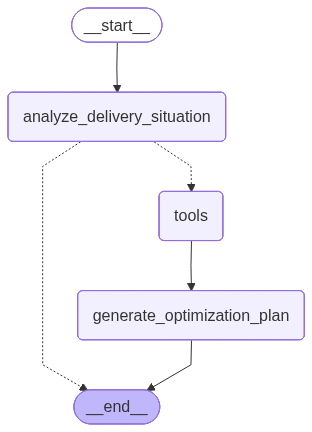

📊 Delivery optimization workflow visualization displayed above


In [7]:
from IPython.display import Image, display

# Display the delivery optimization workflow
try:
    display(Image(delivery_graph.get_graph().draw_mermaid_png()))
    print("📊 Delivery optimization workflow visualization displayed above")
except Exception as e:
    print(f"Note: Visualization requires additional dependencies. Error: {e}")
    print("\nWorkflow structure:")
    print("analyze_delivery_situation → [tools_condition] → tools → generate_optimization_plan → END")
    print("                          ↘ [no tools needed] → END")

## Step 8: Add Memory and Persistence

Enabling the delivery system to maintain context across multiple optimization sessions.

### Memory Benefits for Delivery:
- **Session Continuity**: Remember previous optimization decisions and their outcomes
- **Learning from History**: Track which recommendations were effective
- **Multi-turn Planning**: Handle complex delivery scenarios that require multiple interactions
- **Context Preservation**: Maintain awareness of ongoing delivery issues and their status

In [8]:
from langgraph.checkpoint.memory import MemorySaver

# Add memory to the delivery optimization system
memory = MemorySaver()
delivery_graph = graph_builder.compile(checkpointer=memory)

# Configuration for delivery optimization sessions
config = {"configurable": {"thread_id": "delivery_session_001"}}

print("✅ Memory and persistence enabled for delivery optimization system")
print(f"📝 Session ID: {config['configurable']['thread_id']}")
print("\nMemory features:")
print("- Maintains context across multiple delivery optimizations")
print("- Remembers previous recommendations and outcomes")
print("- Enables follow-up questions and iterative planning")
print("- Tracks ongoing delivery issues and their resolution status")

✅ Memory and persistence enabled for delivery optimization system
📝 Session ID: delivery_session_001

Memory features:
- Maintains context across multiple delivery optimizations
- Remembers previous recommendations and outcomes
- Enables follow-up questions and iterative planning
- Tracks ongoing delivery issues and their resolution status


## Step 9: Test with Delivery Scenarios

Testing our delivery optimization system with realistic scenarios that demonstrate its capabilities.

### Test Scenario 1: Route Delay and Optimization
A common situation where traffic issues cause delivery delays and require immediate route adjustments.

In [9]:
print("🚛 TESTING DELIVERY OPTIMIZATION SYSTEM")
print("=" * 60)

# Test Scenario 1: Route delay and optimization
input_message = """
Route 101 is experiencing significant delays due to an accident on I-5. 
Sarah's truck is currently 45 minutes behind schedule, and she still has 3 high-value deliveries remaining. 
The customer at 789 Pine Rd is already complaining about the delay. 
What should we do to optimize the rest of the route and handle customer communications?
"""

print("📋 SCENARIO: Route delay and optimization")
print("Input:", input_message.strip())
print("\n🤖 DELIVERY OPTIMIZER RESPONSE:")
print("-" * 40)

for step in delivery_graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

🚛 TESTING DELIVERY OPTIMIZATION SYSTEM
📋 SCENARIO: Route delay and optimization
Input: Route 101 is experiencing significant delays due to an accident on I-5. 
Sarah's truck is currently 45 minutes behind schedule, and she still has 3 high-value deliveries remaining. 
The customer at 789 Pine Rd is already complaining about the delay. 
What should we do to optimize the rest of the route and handle customer communications?

🤖 DELIVERY OPTIMIZER RESPONSE:
----------------------------------------
================================ Human Message =================================


Route 101 is experiencing significant delays due to an accident on I-5. 
Sarah's truck is currently 45 minutes behind schedule, and she still has 3 high-value deliveries remaining. 
The customer at 789 Pine Rd is already complaining about the delay. 
What should we do to optimize the rest of the route and handle customer communications?

================================== Ai Message ================================

### Test Scenario 2: Priority Assessment and Customer Communication
Testing how the system handles high-value orders and proactive customer communication.

In [10]:
print("\n" + "=" * 60)
print("📋 SCENARIO 2: Priority assessment and customer communication")

# Test Scenario 2: Priority assessment and customer communication
input_message_2 = """
We need to prioritize deliveries for today across both Route 101 and Route 102. 
Focus on high-value packages and any deliveries that have special customer requirements. 
Also, prepare proactive communication messages for customers about their delivery status.
"""

print("Input:", input_message_2.strip())
print("\n🤖 DELIVERY OPTIMIZER RESPONSE:")
print("-" * 40)

for step in delivery_graph.stream(
    {"messages": [{"role": "user", "content": input_message_2}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()


📋 SCENARIO 2: Priority assessment and customer communication
Input: We need to prioritize deliveries for today across both Route 101 and Route 102. 
Focus on high-value packages and any deliveries that have special customer requirements. 
Also, prepare proactive communication messages for customers about their delivery status.

🤖 DELIVERY OPTIMIZER RESPONSE:
----------------------------------------
================================ Human Message =================================


We need to prioritize deliveries for today across both Route 101 and Route 102. 
Focus on high-value packages and any deliveries that have special customer requirements. 
Also, prepare proactive communication messages for customers about their delivery status.

================================== Ai Message ==================================
Tool Calls:
  get_customer_feedback (call_zArTYxAkGOqHIZnuDtUTHp3v)
 Call ID: call_zArTYxAkGOqHIZnuDtUTHp3v
  Args:
    query: Retrieve all special requirements and feedba

### Test Scenario 3: Follow-up Question
Testing the memory capabilities with a follow-up question about the previous optimization.

In [ ]:
print("\n" + "=" * 60)
print("📋 SCENARIO 3: Follow-up question with memory")

# Test Scenario 3: Follow-up question leveraging memory
input_message_3 = """
Based on the previous recommendations, what specific performance improvements can we expect 
if we implement these changes? Also, how should we track the success of these optimizations?
"""

print("Input:", input_message_3.strip())
print("\n🤖 DELIVERY OPTIMIZER RESPONSE:")
print("-" * 40)

for step in delivery_graph.stream(
    {"messages": [{"role": "user", "content": input_message_3}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

## Step 10: Alternative Approach - ReAct Delivery Agent

Implementing an alternative delivery optimization system using LangGraph's pre-built ReAct agent.

### ReAct Agent Benefits:
- **Reasoning and Acting**: Explicitly shows its thinking process
- **Multi-step Problem Solving**: Can handle complex delivery scenarios requiring multiple tool calls
- **Iterative Approach**: Can gather data, analyze, and then gather more data as needed
- **Built-in Logic**: Includes sophisticated decision-making patterns

### Comparison with Custom Graph:
- **Custom Graph**: Fixed workflow optimized for specific delivery patterns
- **ReAct Agent**: Flexible reasoning that adapts to any delivery scenario
- **Use Cases**: ReAct better for complex, multi-faceted delivery problems

In [11]:
from langgraph.prebuilt import create_react_agent

# Create ReAct agent for delivery optimization
delivery_react_agent = create_react_agent(llm, delivery_tools, checkpointer=memory)

print("✅ ReAct Delivery Agent created successfully!")
print("\nReAct Agent Features:")
print("- Built-in reasoning and action patterns")
print("- Iterative problem-solving approach") 
print("- Flexible tool usage based on reasoning")
print("- Memory-enabled for context continuity")

✅ ReAct Delivery Agent created successfully!

ReAct Agent Features:
- Built-in reasoning and action patterns
- Iterative problem-solving approach
- Flexible tool usage based on reasoning
- Memory-enabled for context continuity


### Visualize ReAct Agent Architecture

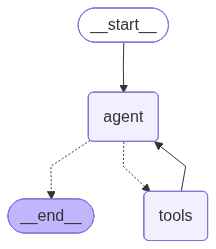

📊 ReAct delivery agent workflow visualization displayed above


In [12]:
# Display ReAct agent workflow visualization
try:
    display(Image(delivery_react_agent.get_graph().draw_mermaid_png()))
    print("📊 ReAct delivery agent workflow visualization displayed above")
except Exception as e:
    print(f"Note: Visualization requires additional dependencies. Error: {e}")
    print("\nReAct Agent structure includes:")
    print("- Agent node for reasoning and decision making")
    print("- Tools node for executing delivery tools")
    print("- Conditional loops for iterative problem solving")
    print("- Built-in memory and state management")

### Test Complex Multi-step Scenario with ReAct Agent

In [13]:
# New conversation thread for ReAct agent testing
react_config = {"configurable": {"thread_id": "react_delivery_session_001"}}

print("🤖 TESTING REACT DELIVERY AGENT")
print("=" * 60)

# Complex multi-step delivery scenario
complex_scenario = """
We have a major delivery crisis today:

1. Route 101 (Sarah's route) is severely delayed due to the I-5 accident
2. We have multiple high-value deliveries that are now at risk
3. Customer at 789 Pine Rd has already complained and is threatening to cancel future orders
4. We need to assess if we can reassign some deliveries to Route 102 (Mike's route)
5. Create a comprehensive recovery plan that includes route optimization, customer communication, and performance tracking

Please analyze all relevant data and create a detailed action plan with specific recommendations and timelines.
"""

print("📋 COMPLEX SCENARIO: Multi-faceted delivery crisis management")
print("Input:", complex_scenario.strip()[:200] + "..." if len(complex_scenario) > 200 else complex_scenario.strip())
print("\n🤖 REACT AGENT RESPONSE:")
print("-" * 40)

for event in delivery_react_agent.stream(
    {"messages": [{"role": "user", "content": complex_scenario}]},
    stream_mode="values",
    config=react_config,
):
    event["messages"][-1].pretty_print()

🤖 TESTING REACT DELIVERY AGENT
📋 COMPLEX SCENARIO: Multi-faceted delivery crisis management
Input: We have a major delivery crisis today:

1. Route 101 (Sarah's route) is severely delayed due to the I-5 accident
2. We have multiple high-value deliveries that are now at risk
3. Customer at 789 Pine ...

🤖 REACT AGENT RESPONSE:
----------------------------------------
================================ Human Message =================================


We have a major delivery crisis today:

1. Route 101 (Sarah's route) is severely delayed due to the I-5 accident
2. We have multiple high-value deliveries that are now at risk
3. Customer at 789 Pine Rd has already complained and is threatening to cancel future orders
4. We need to assess if we can reassign some deliveries to Route 102 (Mike's route)
5. Create a comprehensive recovery plan that includes route optimization, customer communication, and performance tracking

Please analyze all relevant data and create a detailed action plan with